# This Notebook

In this notebook, we'll be working on a data hackathon hosted by Analytics Vidhya. FinMan is a Financial Distribution company. Over the last 10 years, they have created an offline distribution channel across India. They sell financial products to consumers by hiring agents into their network. The agents are freelancers and get commission when they make a product sale. Managers at FinMan are primarily responsible for recruiting agents. Once a manager has identified a potential applicant, they explain the business opportunity to the agent. Once the applicant consents to the contract, an petition is made to FinMan for the applicant to become an agent. The date on which this application is submitted is known as application_receipt_date. Over the next 3 months, the potential agent has to undergo a 7 day training at the FinMan branch (to learn about Sales processes and various products) and clear a subsequent examination in order to become a FinMan agent.

As is obvious in the above process, there is a significant investment which FinMan makes in identifying, training and recruiting these agents. However, there are a set of agents who do not bring in the expected resultant business. The purpose is thus to develop a classifier to identify from the pool of applicants those who will meet business expectations once hired. In the training data, there is a boolean column with zeroes and ones presenting whether a previously hired agent met the business source expectation called `Business_Sourced(Target)` that will serve as our variable to be predicted. From the problem statement, we have a description of all the columns in both train and test sets:

```
Variable 	                    Definition
ID 	                            Unique Application ID
Office_PIN 	                    PINCODE of Fintro's Offices
Application_Receipt_Date 	    Date of Application
Applicant_City_PIN 	            PINCODE of Applicant Address
Applicant_Gender 	            Applicant's Gender
Applicant_BirthDate 	        Applicant's Birthdate
Applicant_Marital_Status 	    Applicant's Marital Status
Applicant_Occupation 	        Applicant's Occupation
Applicant_Qualification 	    Applicant's Educational Qualification
Manager_DOJ 	                Manager's Date of Joining
Manager_Joining_Designation 	Manager's Joining Designation in Fintro
Manager_Current_Designation 	Manager's Designation at the time of application sourcing
Manager_Grade 	                Manager's Grade in Fintro
Manager_Status 	                Current Employment Status (Probation / Confirmation)
Manager_Gender 	                Manager's Gender
Manager_DoB 	                Manager's Birthdate
Manager_Num_Application 	    No. of Applications sourced in last 3 months by the Manager
Manager_Num_Coded 	            No. of agents recruited by the manager in last 3 months
Manager_Business 	            Amount of business sourced by the manager in last 3 months
Manager_Num_Products 	        Number of products sold by the manager in last 3 months
Manager_Business2 	            Amount of business sourced by the manager in last 3 months excluding business from their Category A advisor
Manager_Num_Products2 	        Number of products sold by the manager in last 3 months excluding business from their Category A advisor
```

Looking at this list, there are some columns that, even if they did coincidentally increase the performance of the identifier, I believe we will want to exclude. Some, we may generate a feature from, before removal, such as seeing if the applicant gender and manager gender are the same, but in isolation it wouldn't make sense to include the following as predictors in an ethical classifier: Applicant_City_PIN, Applicant_Gender, Applicant_BirthDate, Applicant_Marital_Status, Manager_Gender, Manager_DoB.

# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix, confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from os import path

In [2]:
train_set = pd.read_csv('./data/train_data.csv')
test_set = pd.read_csv('./data/test_data.csv')

In [3]:
train_set.head()

,ID,Office_PIN,Application_Receipt_Date,Applicant_City_PIN,Applicant_Gender,Applicant_BirthDate,Applicant_Marital_Status,Applicant_Occupation,Applicant_Qualification,Manager_DOJ,...,Manager_Status,Manager_Gender,Manager_DoB,Manager_Num_Application,Manager_Num_Coded,Manager_Business,Manager_Num_Products,Manager_Business2,Manager_Num_Products2,Business_Sourced
0,FIN1000001,842001,4/16/2007,844120.0,M,12/19/1971,M,Others,Graduate,11/10/2005,...,Confirmation,M,2/17/1978,2.0,1.0,335249.0,28.0,335249.0,28.0,0
1,FIN1000002,842001,4/16/2007,844111.0,M,2/17/1983,S,Others,Class XII,11/10/2005,...,Confirmation,M,2/17/1978,2.0,1.0,335249.0,28.0,335249.0,28.0,1
2,FIN1000003,800001,4/16/2007,844101.0,M,1/16/1966,M,Business,Class XII,5/27/2006,...,Confirmation,M,3/3/1969,0.0,0.0,357184.0,24.0,357184.0,24.0,0
3,FIN1000004,814112,4/16/2007,814112.0,M,2/3/1988,S,Salaried,Class XII,8/21/2003,...,Confirmation,F,8/14/1978,0.0,0.0,318356.0,22.0,318356.0,22.0,0
4,FIN1000005,814112,4/16/2007,815351.0,M,7/4/1985,M,Others,Class XII,5/8/2006,...,Confirmation,M,2/7/1971,2.0,1.0,230402.0,17.0,230402.0,17.0,0


In [4]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9527 entries, 0 to 9526
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           9527 non-null   object 
 1   Office_PIN                   9527 non-null   int64  
 2   Application_Receipt_Date     9527 non-null   object 
 3   Applicant_City_PIN           9430 non-null   float64
 4   Applicant_Gender             9460 non-null   object 
 5   Applicant_BirthDate          9454 non-null   object 
 6   Applicant_Marital_Status     9454 non-null   object 
 7   Applicant_Occupation         8306 non-null   object 
 8   Applicant_Qualification      9441 non-null   object 
 9   Manager_DOJ                  8844 non-null   object 
 10  Manager_Joining_Designation  8844 non-null   object 
 11  Manager_Current_Designation  8844 non-null   object 
 12  Manager_Grade                8844 non-null   float64
 13  Manager_Status    

In [5]:
train_set.describe(include = ['int64','float64'])

,Office_PIN,Applicant_City_PIN,Manager_Grade,Manager_Num_Application,Manager_Num_Coded,Manager_Business,Manager_Num_Products,Manager_Business2,Manager_Num_Products2,Business_Sourced
count,9527.000000,9430.000000,8844.000000,8844.000000,8844.000000,8.844000e+03,8844.000000,8.844000e+03,8844.000000,9527.00000
mean,452894.372205,456784.547296,3.264134,1.939733,0.758933,1.843710e+05,7.152307,1.829263e+05,7.131275,0.34292
std,235690.618252,239291.081207,1.137449,2.150529,1.188644,2.747163e+05,8.439351,2.718021e+05,8.423597,0.47471
min,110005.000000,110001.000000,1.000000,0.000000,0.000000,-2.652890e+05,0.000000,-2.652890e+05,0.000000,0.00000
25%,226001.000000,226020.000000,2.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.00000
50%,416001.000000,422005.500000,3.000000,1.000000,0.000000,1.021780e+05,5.000000,1.017140e+05,5.000000,0.00000
75%,695014.000000,695017.000000,4.000000,3.000000,1.000000,2.471165e+05,11.000000,2.464612e+05,11.000000,1.00000
max,851101.000000,995657.000000,10.000000,22.000000,9.000000,3.578265e+06,101.000000,3.578265e+06,101.000000,1.00000


In [6]:
train_set.describe(include = ['object'])

,ID,Application_Receipt_Date,Applicant_Gender,Applicant_BirthDate,Applicant_Marital_Status,Applicant_Occupation,Applicant_Qualification,Manager_DOJ,Manager_Joining_Designation,Manager_Current_Designation,Manager_Status,Manager_Gender,Manager_DoB
count,9527,9527,9460,9454,9454,8306,9441,8844,8844,8844,8844,8844,8844
unique,9527,357,2,5836,4,5,11,646,8,5,2,2,1245
top,FIN1000728,5/9/2007,M,1/3/1978,M,Salaried,Class XII,7/9/2007,Level 1,Level 2,Confirmation,M,2/11/1961
freq,1,165,7179,24,6177,3787,5806,106,4632,3208,5277,7627,45


In [7]:
test_set.head()

,ID,Office_PIN,Application_Receipt_Date,Applicant_City_PIN,Applicant_Gender,Applicant_BirthDate,Applicant_Marital_Status,Applicant_Occupation,Applicant_Qualification,Manager_DOJ,...,Manager_Grade,Manager_Status,Manager_Gender,Manager_DoB,Manager_Num_Application,Manager_Num_Coded,Manager_Business,Manager_Num_Products,Manager_Business2,Manager_Num_Products2
0,FIN1009528,284001,7/2/2008,284001.0,M,8/5/1982,S,Salaried,Graduate,5/26/2008,...,2.0,Probation,F,10/14/1978,1.0,0.0,0.0,0.0,0.0,0.0
1,FIN1009529,800001,7/2/2008,800026.0,M,3/11/1968,M,Salaried,Graduate,6/24/2008,...,2.0,Probation,M,3/3/1971,2.0,0.0,0.0,0.0,0.0,0.0
2,FIN1009530,800001,7/2/2008,NaN,M,12/16/1984,S,NaN,Graduate,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FIN1009531,800001,7/2/2008,844112.0,M,6/7/1971,S,Salaried,Graduate,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FIN1009532,533101,7/2/2008,533102.0,M,7/22/1978,S,NaN,Masters of Business Administration,12/4/2007,...,3.0,Confirmation,M,6/23/1977,4.0,1.0,97352.0,3.0,97352.0,3.0


In [8]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5045 entries, 0 to 5044
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           5045 non-null   object 
 1   Office_PIN                   5045 non-null   int64  
 2   Application_Receipt_Date     5045 non-null   object 
 3   Applicant_City_PIN           5011 non-null   float64
 4   Applicant_Gender             5023 non-null   object 
 5   Applicant_BirthDate          5022 non-null   object 
 6   Applicant_Marital_Status     5015 non-null   object 
 7   Applicant_Occupation         4041 non-null   object 
 8   Applicant_Qualification      5001 non-null   object 
 9   Manager_DOJ                  4221 non-null   object 
 10  Manager_Joining_Designation  4221 non-null   object 
 11  Manager_Current_Designation  4221 non-null   object 
 12  Manager_Grade                4221 non-null   float64
 13  Manager_Status    

In [9]:
test_set.describe(include = ['int64','float64'])

,Office_PIN,Applicant_City_PIN,Manager_Grade,Manager_Num_Application,Manager_Num_Coded,Manager_Business,Manager_Num_Products,Manager_Business2,Manager_Num_Products2
count,5045.000000,5011.000000,4221.000000,4221.000000,4221.000000,4.221000e+03,4221.000000,4.221000e+03,4221.000000
mean,431478.138751,433049.851527,3.352760,2.521204,1.104951,1.115425e+05,3.864250,9.895073e+04,3.495143
std,230425.779147,231655.574011,0.994504,2.491566,1.473985,1.640698e+05,4.688678,1.469193e+05,4.241165
min,110005.000000,110001.000000,2.000000,0.000000,0.000000,-3.196900e+04,0.000000,-3.196900e+04,0.000000
25%,221010.000000,224141.000000,3.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
50%,400705.000000,411005.000000,3.000000,2.000000,1.000000,5.002600e+04,2.000000,4.653700e+04,2.000000
75%,641018.000000,641002.000000,4.000000,4.000000,2.000000,1.757620e+05,7.000000,1.537820e+05,6.000000
max,851101.000000,884112.000000,8.000000,17.000000,10.000000,2.196480e+06,31.000000,2.196480e+06,30.000000


In [10]:
test_set.describe(include = ['object'])

,ID,Application_Receipt_Date,Applicant_Gender,Applicant_BirthDate,Applicant_Marital_Status,Applicant_Occupation,Applicant_Qualification,Manager_DOJ,Manager_Joining_Designation,Manager_Current_Designation,Manager_Status,Manager_Gender,Manager_DoB
count,5045,5045,5023,5022,5015,4041,5001,4221,4221,4221,4221,4221,4221
unique,5045,143,2,3792,4,5,8,465,6,5,2,2,895
top,FIN1012078,7/21/2008,M,1/3/1979,M,Salaried,Graduate,8/4/2008,Level 2,Level 3,Probation,M,5/6/1972
freq,1,273,3900,11,4089,2560,3375,150,1441,1530,2292,3694,32


In [11]:
dates = ['Application_Receipt_Date','Applicant_BirthDate','Manager_DOJ','Manager_DoB']
for column in dates:
    train_set[column] = pd.to_datetime(train_set[column], infer_datetime_format = True)
    test_set[column] = pd.to_datetime(test_set[column], infer_datetime_format = True)

In [12]:
train_set.head()

,ID,Office_PIN,Application_Receipt_Date,Applicant_City_PIN,Applicant_Gender,Applicant_BirthDate,Applicant_Marital_Status,Applicant_Occupation,Applicant_Qualification,Manager_DOJ,...,Manager_Status,Manager_Gender,Manager_DoB,Manager_Num_Application,Manager_Num_Coded,Manager_Business,Manager_Num_Products,Manager_Business2,Manager_Num_Products2,Business_Sourced
0,FIN1000001,842001,2007-04-16,844120.0,M,1971-12-19,M,Others,Graduate,2005-11-10,...,Confirmation,M,1978-02-17,2.0,1.0,335249.0,28.0,335249.0,28.0,0
1,FIN1000002,842001,2007-04-16,844111.0,M,1983-02-17,S,Others,Class XII,2005-11-10,...,Confirmation,M,1978-02-17,2.0,1.0,335249.0,28.0,335249.0,28.0,1
2,FIN1000003,800001,2007-04-16,844101.0,M,1966-01-16,M,Business,Class XII,2006-05-27,...,Confirmation,M,1969-03-03,0.0,0.0,357184.0,24.0,357184.0,24.0,0
3,FIN1000004,814112,2007-04-16,814112.0,M,1988-02-03,S,Salaried,Class XII,2003-08-21,...,Confirmation,F,1978-08-14,0.0,0.0,318356.0,22.0,318356.0,22.0,0
4,FIN1000005,814112,2007-04-16,815351.0,M,1985-07-04,M,Others,Class XII,2006-05-08,...,Confirmation,M,1971-02-07,2.0,1.0,230402.0,17.0,230402.0,17.0,0


In [13]:
test_set.head()

,ID,Office_PIN,Application_Receipt_Date,Applicant_City_PIN,Applicant_Gender,Applicant_BirthDate,Applicant_Marital_Status,Applicant_Occupation,Applicant_Qualification,Manager_DOJ,...,Manager_Grade,Manager_Status,Manager_Gender,Manager_DoB,Manager_Num_Application,Manager_Num_Coded,Manager_Business,Manager_Num_Products,Manager_Business2,Manager_Num_Products2
0,FIN1009528,284001,2008-07-02,284001.0,M,1982-08-05,S,Salaried,Graduate,2008-05-26,...,2.0,Probation,F,1978-10-14,1.0,0.0,0.0,0.0,0.0,0.0
1,FIN1009529,800001,2008-07-02,800026.0,M,1968-03-11,M,Salaried,Graduate,2008-06-24,...,2.0,Probation,M,1971-03-03,2.0,0.0,0.0,0.0,0.0,0.0
2,FIN1009530,800001,2008-07-02,NaN,M,1984-12-16,S,NaN,Graduate,NaT,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,FIN1009531,800001,2008-07-02,844112.0,M,1971-06-07,S,Salaried,Graduate,NaT,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,FIN1009532,533101,2008-07-02,533102.0,M,1978-07-22,S,NaN,Masters of Business Administration,2007-12-04,...,3.0,Confirmation,M,1977-06-23,4.0,1.0,97352.0,3.0,97352.0,3.0


In [14]:
for column in train_set.columns:
    if train_set[column].dtype == 'object' and column != 'ID':
        print('=================================')
        print(f'Column Name: {column}')
        print(train_set[column].value_counts(dropna = False))
        print('=================================')

Column Name: Applicant_Gender
M      7179
F      2281
NaN      67
Name: Applicant_Gender, dtype: int64
Column Name: Applicant_Marital_Status
M      6177
S      3267
NaN      73
W         6
D         4
Name: Applicant_Marital_Status, dtype: int64
Column Name: Applicant_Occupation
Salaried         3787
Business         2303
Others           1966
NaN              1221
Self Employed     149
Student           101
Name: Applicant_Occupation, dtype: int64
Column Name: Applicant_Qualification
Class XII                                                           5806
Graduate                                                            3196
Class X                                                              225
Others                                                               132
NaN                                                                   86
Masters of Business Administration                                    74
Associate / Fellow of Institute of Chartered Accountans of India       3

In [15]:
for column in test_set.columns:
    if test_set[column].dtype == 'object' and column != 'ID':
        print('=================================')
        print(f'Column Name: {column}')
        print(test_set[column].value_counts(dropna = False))
        print('=================================')

Column Name: Applicant_Gender
M      3900
F      1123
NaN      22
Name: Applicant_Gender, dtype: int64
Column Name: Applicant_Marital_Status
M      4089
S       907
NaN      30
W        12
D         7
Name: Applicant_Marital_Status, dtype: int64
Column Name: Applicant_Occupation
Salaried         2560
NaN              1004
Business          646
Others            506
Self Employed     310
Student            19
Name: Applicant_Occupation, dtype: int64
Column Name: Applicant_Qualification
Graduate                                                                              3375
Class XII                                                                             1357
Others                                                                                 171
Masters of Business Administration                                                      71
NaN                                                                                     44
Class X                                                

In columns `Applicant_Qualification` and `Manager_Joining_Designation` there are different unique identifiers. We will have to bin some of them to make the different indentifiers uniform for best performance. We're also seeing significant and annoying NaN counts in these columns, as well as in our numeric columns as is apparent in the df.info().

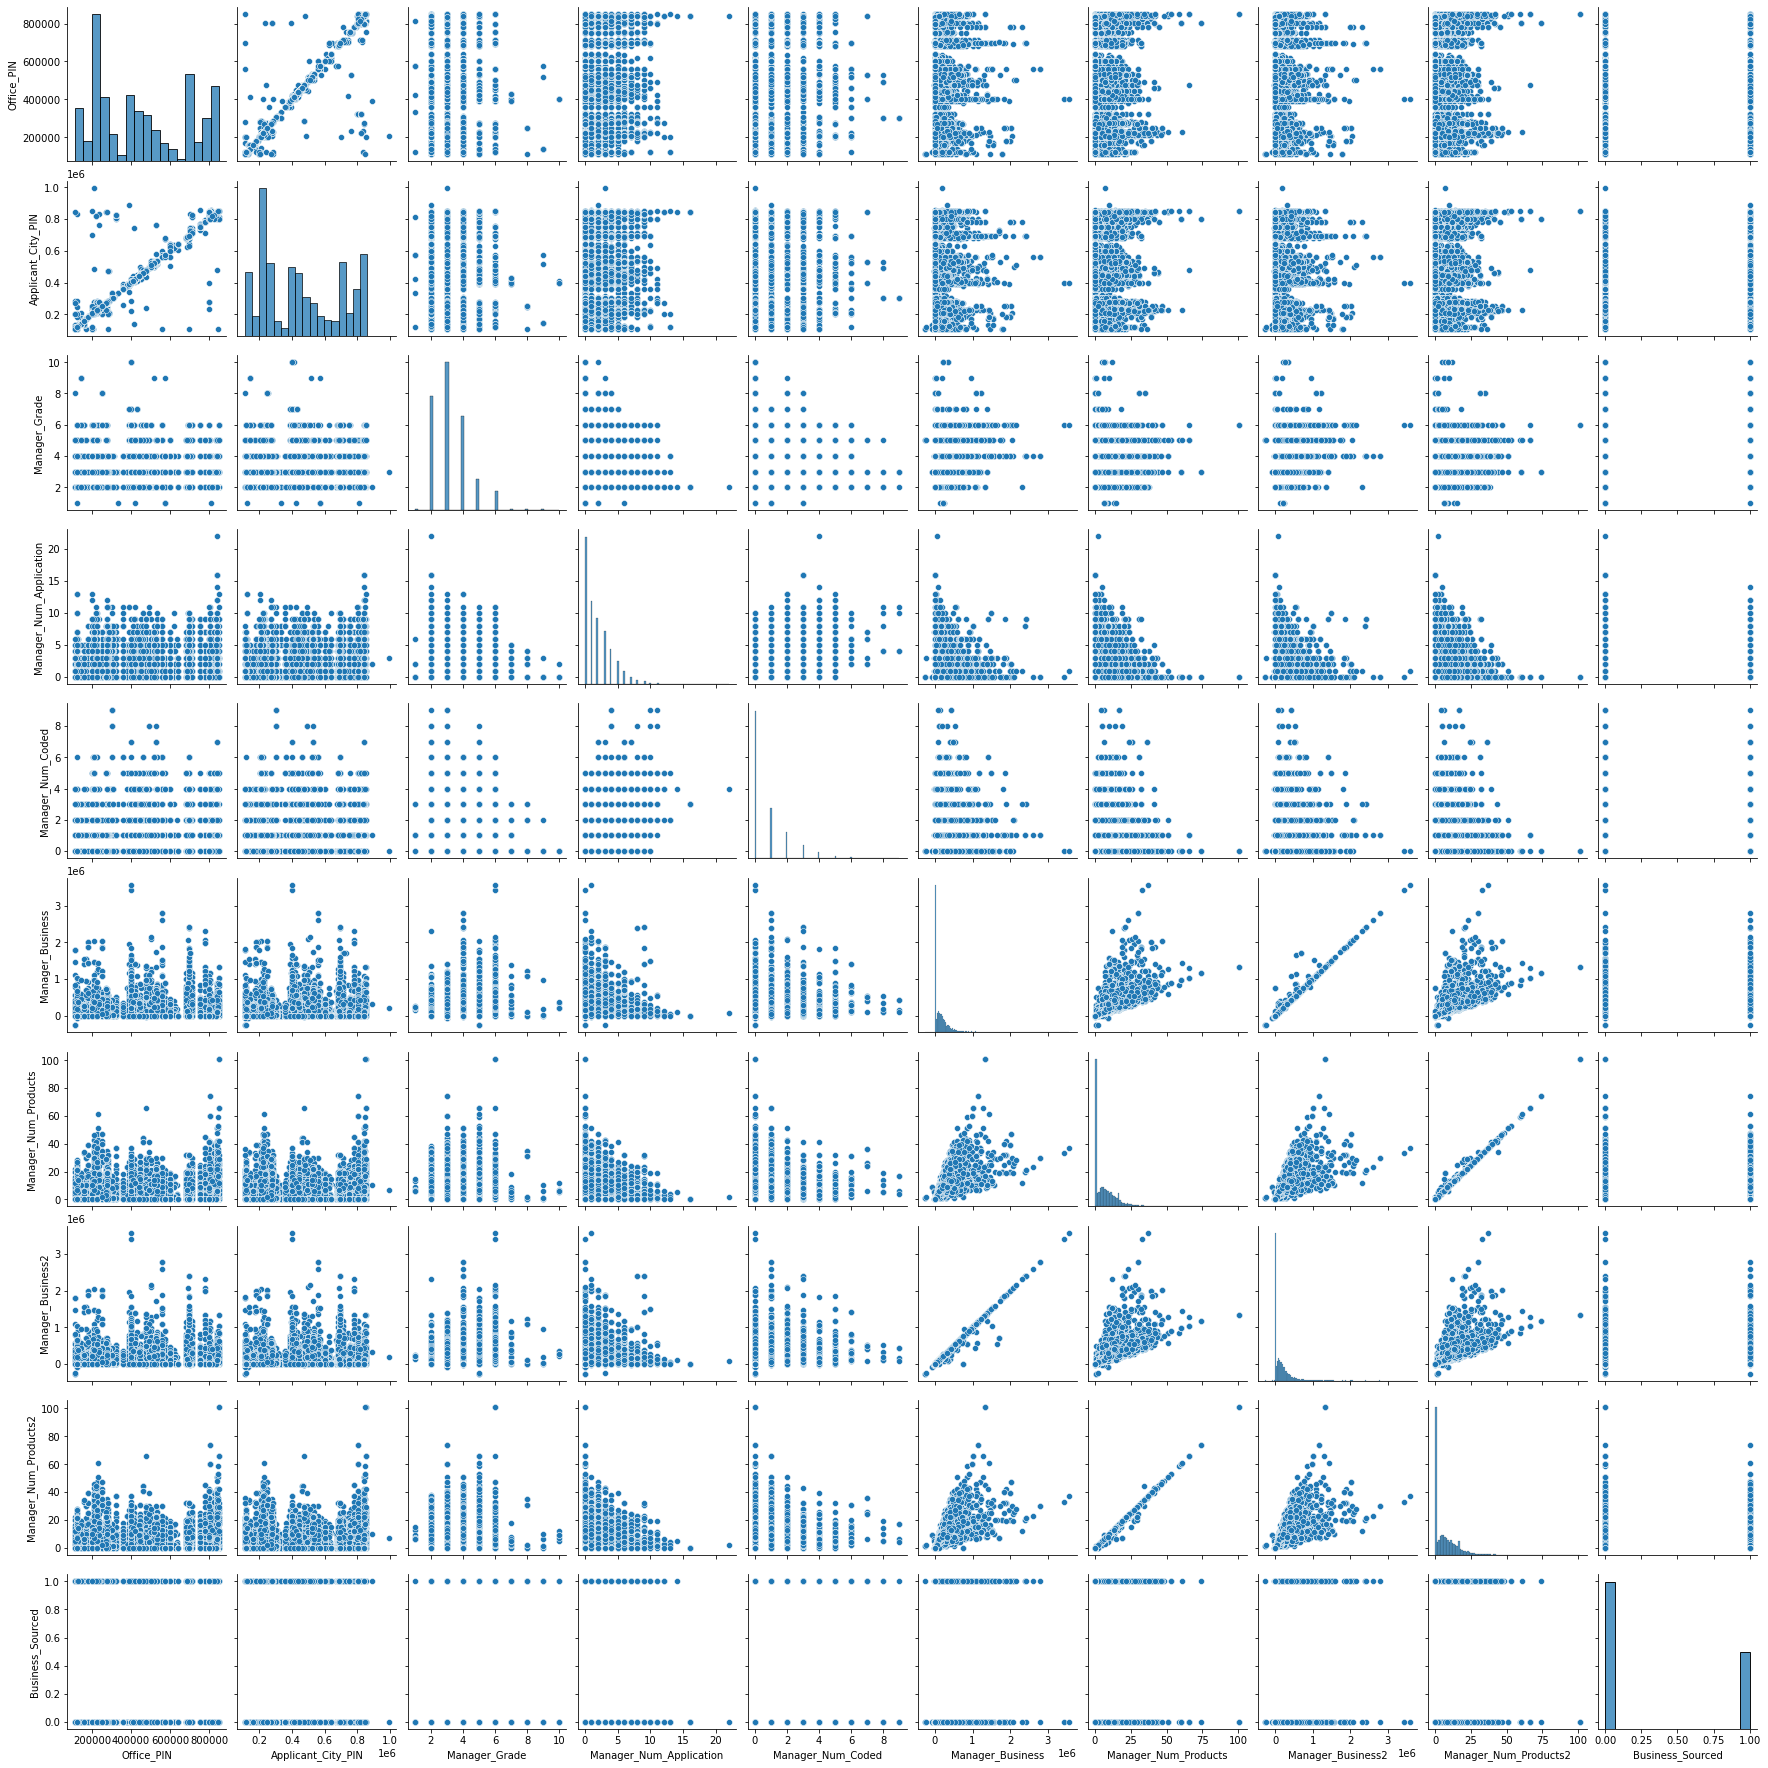

In [51]:
sns.pairplot(data = train_set)

<AxesSubplot:>

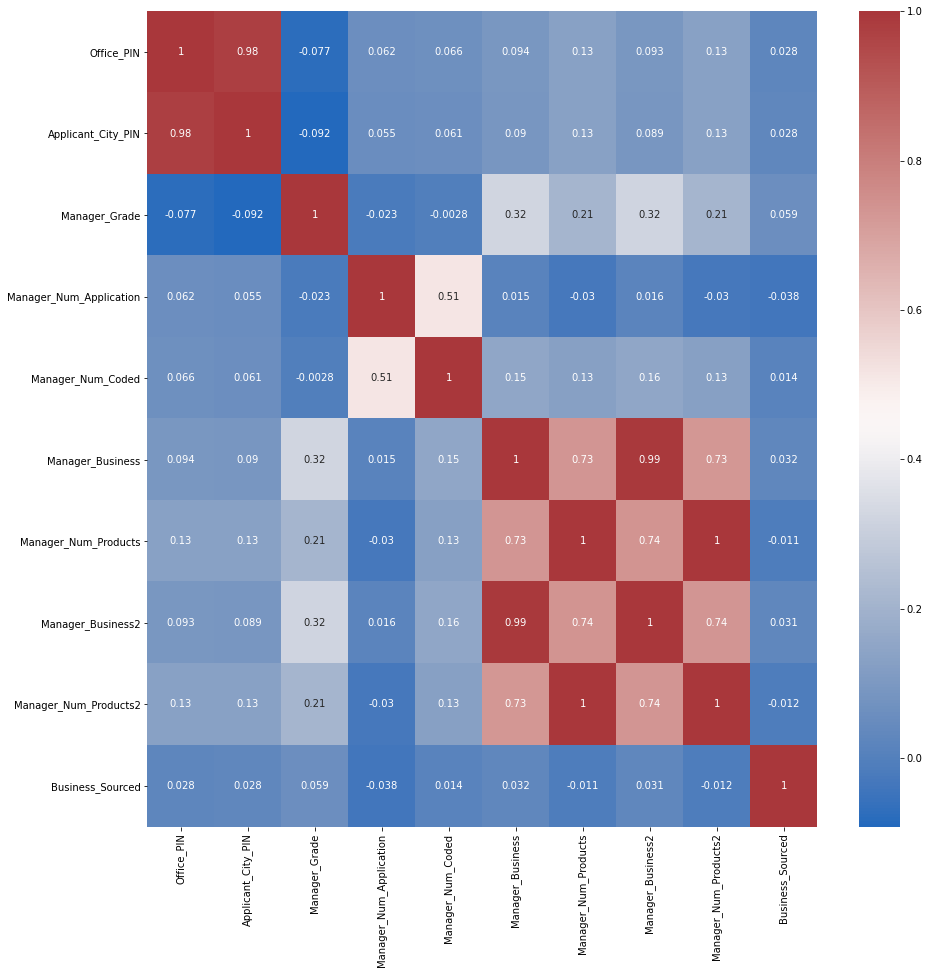

In [52]:
plt.figure(figsize = (15,15))
sns.heatmap(data = train_set.corr(), annot = True, cmap = 'vlag')

In [16]:
train_set.columns

Index(['ID', 'Office_PIN', 'Application_Receipt_Date', 'Applicant_City_PIN',
       'Applicant_Gender', 'Applicant_BirthDate', 'Applicant_Marital_Status',
       'Applicant_Occupation', 'Applicant_Qualification', 'Manager_DOJ',
       'Manager_Joining_Designation', 'Manager_Current_Designation',
       'Manager_Grade', 'Manager_Status', 'Manager_Gender', 'Manager_DoB',
       'Manager_Num_Application', 'Manager_Num_Coded', 'Manager_Business',
       'Manager_Num_Products', 'Manager_Business2', 'Manager_Num_Products2',
       'Business_Sourced'],
      dtype='object')

Okay, first we'll use the column list to create two new data structures on which to begin modifying our original data as part of the cleaning process. We will forego including columns Applicant_City_PIN, Applicant_Gender, Applicant_BirthDate, Applicant_Marital_Status, Manager_Gender, and Manager_DoB for ethical reasons. We may however use them to construct additional features post-baseline modeling in concurrence with some of the other features. It could be interesting to include them in the classifier, because, should any of them prove useful as a metric, the best takeaway from that conclusion would be that the business has ethical concerns affecting agent success that need to be addressed. In the interest of making the most general model, we choose not to include them here. Similarly, while not as much of an ethical concern, Office_Pin and Applicant_Receipt_Date do not seem like they should inform the prediction in any way. It is possible that some offices perform better than others, and that the environment influencing success was different for each candidate based on their start date and work location, but again, if this is the case, it would lead to a lack of generality in the model and would indicate a concern to be addressed internally, so these columns are also not included. Finally, since it is just a unique identifier, ID is not included.

In [17]:
train_set_predictors = train_set[['Applicant_Occupation', 'Applicant_Qualification', 
       'Manager_DOJ', 'Manager_Joining_Designation', 'Manager_Current_Designation',
       'Manager_Grade', 'Manager_Status', 'Manager_Num_Application',
       'Manager_Num_Coded', 'Manager_Business', 'Manager_Num_Products',
       'Manager_Business2', 'Manager_Num_Products2']].copy()
train_set_targ = train_set['Business_Sourced'].copy()
test_predictors = test_set[['Applicant_Occupation', 'Applicant_Qualification', 'Manager_DOJ',
       'Manager_Joining_Designation', 'Manager_Current_Designation',
       'Manager_Grade', 'Manager_Status', 'Manager_Num_Application',
       'Manager_Num_Coded', 'Manager_Business', 'Manager_Num_Products',
       'Manager_Business2', 'Manager_Num_Products2']].copy()

In [18]:
train_set_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9527 entries, 0 to 9526
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Applicant_Occupation         8306 non-null   object        
 1   Applicant_Qualification      9441 non-null   object        
 2   Manager_DOJ                  8844 non-null   datetime64[ns]
 3   Manager_Joining_Designation  8844 non-null   object        
 4   Manager_Current_Designation  8844 non-null   object        
 5   Manager_Grade                8844 non-null   float64       
 6   Manager_Status               8844 non-null   object        
 7   Manager_Num_Application      8844 non-null   float64       
 8   Manager_Num_Coded            8844 non-null   float64       
 9   Manager_Business             8844 non-null   float64       
 10  Manager_Num_Products         8844 non-null   float64       
 11  Manager_Business2            8844 non-null 

In [19]:
test_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5045 entries, 0 to 5044
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Applicant_Occupation         4041 non-null   object        
 1   Applicant_Qualification      5001 non-null   object        
 2   Manager_DOJ                  4221 non-null   datetime64[ns]
 3   Manager_Joining_Designation  4221 non-null   object        
 4   Manager_Current_Designation  4221 non-null   object        
 5   Manager_Grade                4221 non-null   float64       
 6   Manager_Status               4221 non-null   object        
 7   Manager_Num_Application      4221 non-null   float64       
 8   Manager_Num_Coded            4221 non-null   float64       
 9   Manager_Business             4221 non-null   float64       
 10  Manager_Num_Products         4221 non-null   float64       
 11  Manager_Business2            4221 non-null 

Now, to make some changes. Let's prepare the remaining columns for OHE or label encoding, depending on the column. First, we will replace all of the NaNs in the non-ordinal categories with 'Unknown'.

In [20]:
for column in train_set_predictors.columns:
    if train_set_predictors[column].dtype == 'object':
        print('=================================')
        print(f'Column Name: {column}')
        print(train_set_predictors[column].value_counts(dropna = False))
        print('=================================')

Column Name: Applicant_Occupation
Salaried         3787
Business         2303
Others           1966
NaN              1221
Self Employed     149
Student           101
Name: Applicant_Occupation, dtype: int64
Column Name: Applicant_Qualification
Class XII                                                           5806
Graduate                                                            3196
Class X                                                              225
Others                                                               132
NaN                                                                   86
Masters of Business Administration                                    74
Associate / Fellow of Institute of Chartered Accountans of India       3
Associate/Fellow of Institute of Company Secretories of India          1
Professional Qualification in Marketing                                1
Certified Associateship of Indian Institute of Bankers                 1
Associate/Fellow of Insura

In [21]:
for column in test_predictors.columns:
    if test_predictors[column].dtype == 'object':
        print('=================================')
        print(f'Column Name: {column}')
        print(test_predictors[column].value_counts(dropna = False))
        print('=================================')

Column Name: Applicant_Occupation
Salaried         2560
NaN              1004
Business          646
Others            506
Self Employed     310
Student            19
Name: Applicant_Occupation, dtype: int64
Column Name: Applicant_Qualification
Graduate                                                                              3375
Class XII                                                                             1357
Others                                                                                 171
Masters of Business Administration                                                      71
NaN                                                                                     44
Class X                                                                                 19
Professional Qualification in Marketing                                                  5
Associate / Fellow of Institute of Chartered Accountans of India                         2
Associate/Fellow of Institut

There are pretty large numbers of NaNs in some of these columns.. not great. Anyway, let's work with the non-ordinal categories, first replacing the NaNs with unknown, then binning some of the smaller groups into 'Other'. 

In [22]:
non_ordinal = ['Applicant_Occupation', 'Applicant_Qualification', 'Manager_Status']
for column in non_ordinal:
    train_set_predictors[column] = train_set_predictors[column].fillna(value = 'Unknown')
    test_predictors[column] = test_predictors[column].fillna(value = 'Unknown')

In [23]:
train_set_predictors.Applicant_Qualification.value_counts()[train_set_predictors.Applicant_Qualification.value_counts() <= 10].index

Index(['Associate / Fellow of Institute of Chartered Accountans of India',
       'Associate/Fellow of Institute of Company Secretories of India',
       'Professional Qualification in Marketing',
       'Certified Associateship of Indian Institute of Bankers',
       'Associate/Fellow of Insurance Institute of India',
       'Associate/Fellow of Acturial Society of India'],
      dtype='object')

In [24]:
for column in non_ordinal:
    for category in train_set_predictors[column].value_counts()[train_set_predictors[column].value_counts() <= 10].index:
        train_set_predictors[column] = train_set_predictors[column].str.replace(category,'Others')
    for category in test_predictors[column].value_counts()[test_predictors[column].value_counts() <= 10].index:
        test_predictors[column] = test_predictors[column].str.replace(category,'Others')

In [25]:
for column in train_set_predictors.columns:
    if train_set_predictors[column].dtype == 'object':
        print('=================================')
        print(f'Column Name: {column}')
        print(train_set_predictors[column].value_counts(dropna = False))
        print('=================================')

Column Name: Applicant_Occupation
Salaried         3787
Business         2303
Others           1966
Unknown          1221
Self Employed     149
Student           101
Name: Applicant_Occupation, dtype: int64
Column Name: Applicant_Qualification
Class XII                             5806
Graduate                              3196
Class X                                225
Others                                 140
Unknown                                 86
Masters of Business Administration      74
Name: Applicant_Qualification, dtype: int64
Column Name: Manager_Joining_Designation
Level 1    4632
Level 2    2787
Level 3    1146
NaN         683
Level 4     200
Other        58
Level 6      18
Level 7       2
Level 5       1
Name: Manager_Joining_Designation, dtype: int64
Column Name: Manager_Current_Designation
Level 2    3208
Level 1    2479
Level 3    2033
Level 4    1031
NaN         683
Level 5      93
Name: Manager_Current_Designation, dtype: int64
Column Name: Manager_Status
Confirma

In [26]:
for column in test_predictors.columns:
    if test_predictors[column].dtype == 'object':
        print('=================================')
        print(f'Column Name: {column}')
        print(test_predictors[column].value_counts(dropna = False))
        print('=================================')

Column Name: Applicant_Occupation
Salaried         2560
Unknown          1004
Business          646
Others            506
Self Employed     310
Student            19
Name: Applicant_Occupation, dtype: int64
Column Name: Applicant_Qualification
Graduate                              3375
Class XII                             1357
Others                                 179
Masters of Business Administration      71
Unknown                                 44
Class X                                 19
Name: Applicant_Qualification, dtype: int64
Column Name: Manager_Joining_Designation
Level 2    1441
Level 3    1337
Level 1    1217
NaN         824
Level 4     208
Level 5      15
Level 6       3
Name: Manager_Joining_Designation, dtype: int64
Column Name: Manager_Current_Designation
Level 3    1530
Level 2    1440
Level 1     887
NaN         824
Level 4     334
Level 5      30
Name: Manager_Current_Designation, dtype: int64
Column Name: Manager_Status
Probation       2292
Confirmation    192

Okay, looks like it worked! Now let's dummy encode them as the last step.

In [27]:
for column in non_ordinal:
    drop_cat = train_set_predictors[column].value_counts().index[0]
    dummies_train = pd.get_dummies(train_set_predictors[column], prefix = column)
    dummies_test = pd.get_dummies(test_predictors[column], prefix = column)
    train_set_predictors = pd.concat([train_set_predictors, dummies_train], axis = 1)
    test_predictors = pd.concat([test_predictors, dummies_test], axis = 1)
    train_set_predictors.drop(columns = [column, column + '_' + drop_cat], inplace = True)
    test_predictors.drop(columns = [column, column + '_' + drop_cat], inplace = True)

In [28]:
train_set_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9527 entries, 0 to 9526
Data columns (total 22 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Manager_DOJ                                                 8844 non-null   datetime64[ns]
 1   Manager_Joining_Designation                                 8844 non-null   object        
 2   Manager_Current_Designation                                 8844 non-null   object        
 3   Manager_Grade                                               8844 non-null   float64       
 4   Manager_Num_Application                                     8844 non-null   float64       
 5   Manager_Num_Coded                                           8844 non-null   float64       
 6   Manager_Business                                            8844 non-null   float64       
 7   Manager_Num_Products    

In [29]:
test_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5045 entries, 0 to 5044
Data columns (total 22 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Manager_DOJ                                                 4221 non-null   datetime64[ns]
 1   Manager_Joining_Designation                                 4221 non-null   object        
 2   Manager_Current_Designation                                 4221 non-null   object        
 3   Manager_Grade                                               4221 non-null   float64       
 4   Manager_Num_Application                                     4221 non-null   float64       
 5   Manager_Num_Coded                                           4221 non-null   float64       
 6   Manager_Business                                            4221 non-null   float64       
 7   Manager_Num_Products    

Now, let's deal with the ordinal columns. The ordinal columns present a unique challenge because, where do we put unknowns in the ranking? They are large enough portions of the dataset that it presents concerns with skewing the original data in bias by random chance with improper imputation methods. Imputing either the mean or mode seems like it will almost definitely cause this to happen, so I think the best method is frequency based random imputation, at least to start. Now, we must remember that we should use the training data frequencies to impute values into the test set, because we fit our transformation on the training set, not the test set. Also, since other is meaningless in this context and there are very few of them, let's replace Other with NaNs that will then be randomly distributed to the other levels.

In [30]:
ordinal = ['Manager_Joining_Designation','Manager_Current_Designation']
rng = np.random.default_rng(4)
for column in ordinal:
    train_set_predictors[column] = train_set_predictors[column].replace('Other',np.nan)
    freqs = train_set_predictors[column].value_counts(normalize = True)
    train_set_predictors.loc[train_set_predictors[column].isna(), column] = rng.choice(
        freqs.index, p = freqs.values, size = train_set_predictors[column].isna().sum())
    test_predictors.loc[test_predictors[column].isna(), column] = rng.choice(
        freqs.index, p = freqs.values, size = test_predictors[column].isna().sum())

In [31]:
for column in train_set_predictors.columns:
    if train_set_predictors[column].dtype == 'object':
        print('=================================')
        print(f'Column Name: {column}')
        print(train_set_predictors[column].value_counts(dropna = False))
        print('=================================')

Column Name: Manager_Joining_Designation
Level 1    5008
Level 2    3029
Level 3    1255
Level 4     213
Level 6      19
Level 7       2
Level 5       1
Name: Manager_Joining_Designation, dtype: int64
Column Name: Manager_Current_Designation
Level 2    3453
Level 1    2674
Level 3    2183
Level 4    1121
Level 5      96
Name: Manager_Current_Designation, dtype: int64


In [32]:
for column in test_predictors.columns:
    if test_predictors[column].dtype == 'object':
        print('=================================')
        print(f'Column Name: {column}')
        print(test_predictors[column].value_counts(dropna = False))
        print('=================================')

Column Name: Manager_Joining_Designation
Level 2    1697
Level 1    1662
Level 3    1439
Level 4     226
Level 5      15
Level 6       6
Name: Manager_Joining_Designation, dtype: int64
Column Name: Manager_Current_Designation
Level 2    1728
Level 3    1717
Level 1    1125
Level 4     436
Level 5      39
Name: Manager_Current_Designation, dtype: int64


Okay, looks good on that front. Now, lets encode them using OrdinalEncoder.

In [33]:
ordenc = OrdinalEncoder()
ordenc.fit(train_set_predictors[ordinal])
ordenc.categories_

[array(['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5', 'Level 6',
        'Level 7'], dtype=object),
 array(['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5'],
       dtype=object)]

In [34]:
train_set_predictors[ordinal] = ordenc.transform(train_set_predictors[ordinal])
test_predictors[ordinal] = ordenc.transform(test_predictors[ordinal])

In [35]:
train_set_predictors['Manager_Joining_Designation'].value_counts()

0.0    5008
1.0    3029
2.0    1255
3.0     213
5.0      19
6.0       2
4.0       1
Name: Manager_Joining_Designation, dtype: int64

In [36]:
test_predictors['Manager_Joining_Designation'].value_counts()

1.0    1697
0.0    1662
2.0    1439
3.0     226
4.0      15
5.0       6
Name: Manager_Joining_Designation, dtype: int64

Okay! Looking solid. Now let's move on to missing values for our other columns, the ones that were our original numeric columns. I suspect some of them, based on the column names and provided info, are already label encoded or ordinal categories, so let's look at value_counts real quick.

In [37]:
remaining_cols = ['Manager_DOJ','Manager_Grade','Manager_Num_Application','Manager_Num_Coded','Manager_Business','Manager_Num_Products','Manager_Business2','Manager_Num_Products2']
for column in remaining_cols:
    print('=================================')
    print(f'Column Name: {column}')
    print("Train Counts:")
    print(train_set_predictors[column].value_counts(dropna = False))
    print("Test Counts:")
    print(test_predictors[column].value_counts(dropna = False))
    print('=================================')

Column Name: Manager_DOJ
Train Counts:
NaT           683
2007-07-09    106
2007-06-11     76
2007-11-06     71
2006-05-08     69
             ... 
2001-07-25      1
2004-12-04      1
2006-01-10      1
2006-11-22      1
2006-11-28      1
Name: Manager_DOJ, Length: 647, dtype: int64
Test Counts:
NaT           824
2008-08-04    150
2008-10-02    107
2008-06-02     89
2008-07-02     69
             ... 
2007-08-04      1
2006-05-25      1
2008-05-20      1
2008-03-21      1
2008-03-31      1
Name: Manager_DOJ, Length: 466, dtype: int64
Column Name: Manager_Grade
Train Counts:
3.0     3207
2.0     2471
4.0     2038
NaN      683
5.0      666
6.0      406
7.0       22
8.0       14
1.0        8
9.0        7
10.0       5
Name: Manager_Grade, dtype: int64
Test Counts:
4.0    1507
3.0    1445
2.0     905
NaN     824
5.0     220
6.0     132
7.0       9
8.0       3
Name: Manager_Grade, dtype: int64
Column Name: Manager_Num_Application
Train Counts:
0.0     2980
1.0     1677
2.0     1339
3.0     107

For these, we can impute values for the NaNs by the same treatment, random frequency based replacement, as we did for the ordinal columns above. We may also be able to turn DOJ into a more easily understood column, such as tenure in month or years, to which that can also be applied. Let's start with replacing the DOJ column with tenure. 

In [38]:
train_set_predictors['Manager_DOJ'].dt.year.value_counts()

2007.0    3286
2006.0    2043
2008.0     954
2003.0     820
2004.0     638
2005.0     521
2001.0     294
2002.0     288
Name: Manager_DOJ, dtype: int64

Years since joining seems like a fine enough way to bin them.

In [39]:
train_set_predictors['Manager_YOJ'] = train_set_predictors['Manager_DOJ'].dt.year
test_predictors['Manager_YOJ'] = test_predictors['Manager_DOJ'].dt.year

In [40]:
train_set_predictors['Manager_YOJ'].value_counts(dropna = False)

2007.0    3286
2006.0    2043
2008.0     954
2003.0     820
NaN        683
2004.0     638
2005.0     521
2001.0     294
2002.0     288
Name: Manager_YOJ, dtype: int64

In [41]:
train_set_predictors = train_set_predictors.drop(columns = ['Manager_DOJ'])
test_predictors = test_predictors.drop(columns = ['Manager_DOJ'])

In [43]:
PMF_cols = ['Manager_YOJ','Manager_Grade','Manager_Num_Application','Manager_Num_Coded','Manager_Business','Manager_Num_Products','Manager_Business2','Manager_Num_Products2']
for column in PMF_cols:
    freqs = train_set_predictors[column].value_counts(normalize = True)
    train_set_predictors.loc[train_set_predictors[column].isna(), column] = rng.choice(
        freqs.index, p = freqs.values, size = train_set_predictors[column].isna().sum())
    test_predictors.loc[test_predictors[column].isna(), column] = rng.choice(
        freqs.index, p = freqs.values, size = test_predictors[column].isna().sum())

In [50]:
remaining_cols = ['Manager_YOJ','Manager_Grade','Manager_Num_Application','Manager_Num_Coded','Manager_Business','Manager_Num_Products','Manager_Business2','Manager_Num_Products2']
for column in remaining_cols:
    print('=================================')
    print(f'Column Name: {column}')
    print("Train Counts:")
    print(train_set_predictors[column].value_counts(dropna = False))
    print("Test Counts:")
    print(test_predictors[column].value_counts(dropna = False))
    print('=================================')

Column Name: Manager_YOJ
Train Counts:
2007.0    3528
2006.0    2198
2008.0    1023
2003.0     890
2004.0     687
2005.0     567
2001.0     320
2002.0     314
Name: Manager_YOJ, dtype: int64
Test Counts:
2008.0    2652
2007.0     833
2006.0     573
2003.0     345
2004.0     248
2005.0     185
2002.0     119
2001.0      90
Name: Manager_YOJ, dtype: int64
Column Name: Manager_Grade
Train Counts:
3.0     3473
2.0     2636
4.0     2200
5.0      714
6.0      437
7.0       29
8.0       14
9.0        9
1.0        9
10.0       6
Name: Manager_Grade, dtype: int64
Test Counts:
3.0    1718
4.0    1694
2.0    1171
5.0     277
6.0     171
7.0      10
8.0       3
1.0       1
Name: Manager_Grade, dtype: int64
Column Name: Manager_Num_Application
Train Counts:
0.0     3213
1.0     1793
2.0     1452
3.0     1161
4.0      756
5.0      503
6.0      292
7.0      142
8.0       90
9.0       66
10.0      27
11.0      15
16.0       6
12.0       5
13.0       4
14.0       1
22.0       1
Name: Manager_Num_Applic

In [44]:
train_set_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9527 entries, 0 to 9526
Data columns (total 22 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Manager_Joining_Designation                                 9527 non-null   float64
 1   Manager_Current_Designation                                 9527 non-null   float64
 2   Manager_Grade                                               9527 non-null   float64
 3   Manager_Num_Application                                     9527 non-null   float64
 4   Manager_Num_Coded                                           9527 non-null   float64
 5   Manager_Business                                            9527 non-null   float64
 6   Manager_Num_Products                                        9527 non-null   float64
 7   Manager_Business2                                           9527 non-null   float64
 8 

In [45]:
test_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5045 entries, 0 to 5044
Data columns (total 22 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Manager_Joining_Designation                                 5045 non-null   float64
 1   Manager_Current_Designation                                 5045 non-null   float64
 2   Manager_Grade                                               5045 non-null   float64
 3   Manager_Num_Application                                     5045 non-null   float64
 4   Manager_Num_Coded                                           5045 non-null   float64
 5   Manager_Business                                            5045 non-null   float64
 6   Manager_Num_Products                                        5045 non-null   float64
 7   Manager_Business2                                           5045 non-null   float64
 8 

<AxesSubplot:>

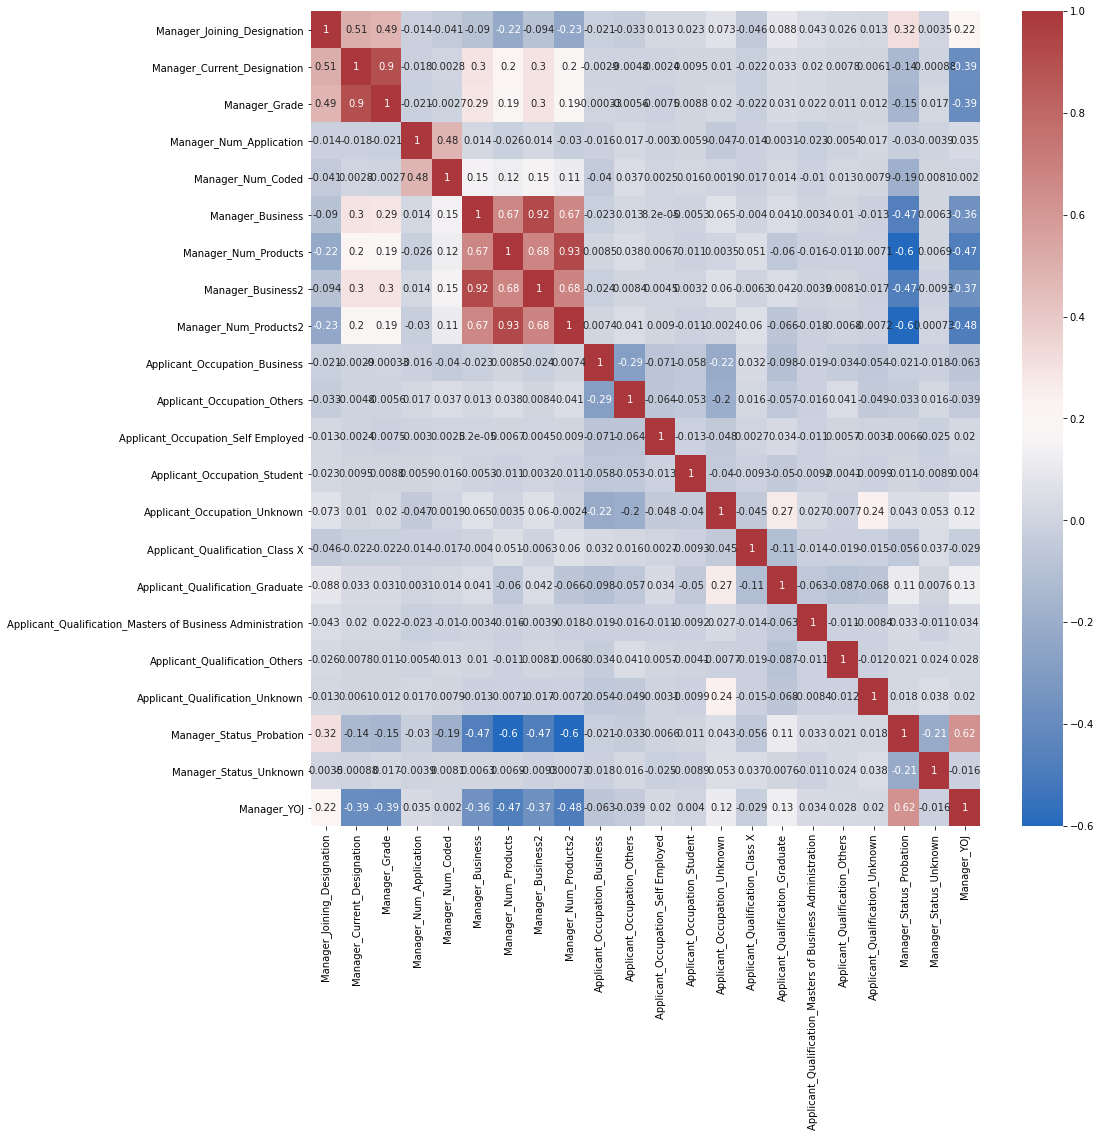

In [47]:
plt.figure(figsize = (15,15))
sns.heatmap(data = train_set_predictors.corr(), annot = True, cmap = 'vlag')

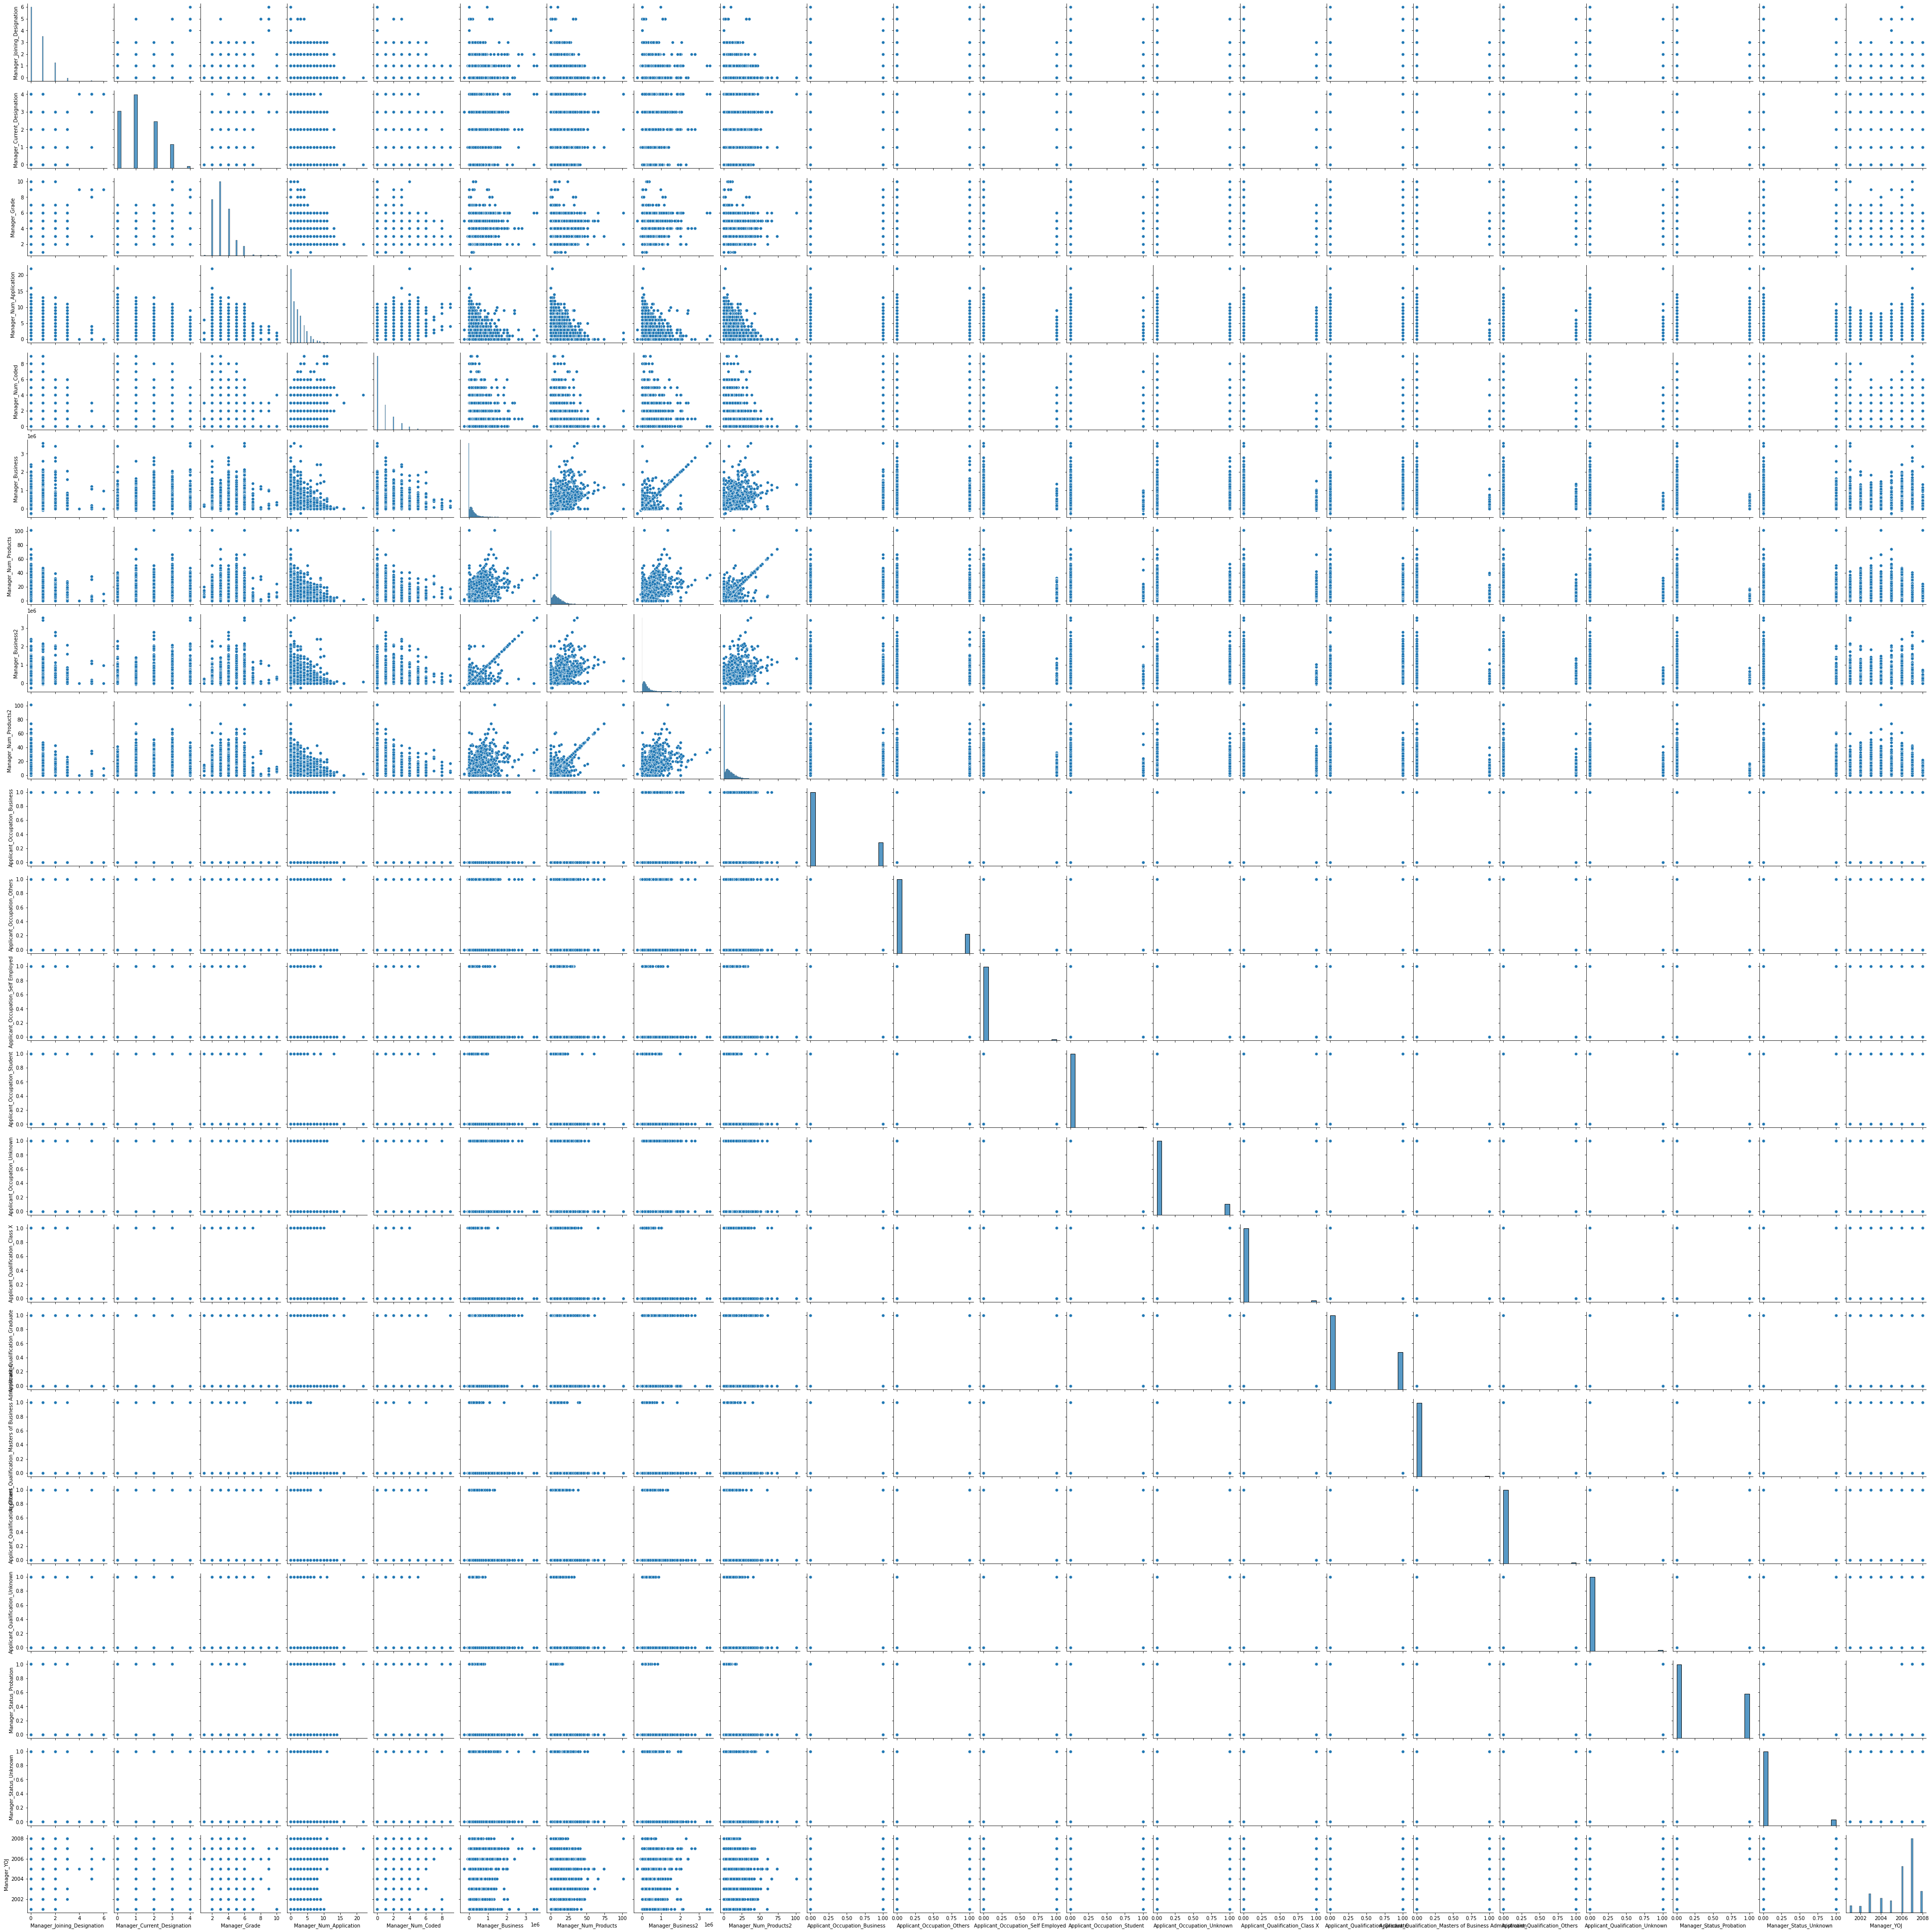

In [48]:
sns.pairplot(data = train_set_predictors)

Okay! We have dealt with all the missing values, and prepared categorical features. Let's get into some baselines!

# Baseline Models